In [2]:
import numpy as np
import matplotlib.pyplot as plt

date: 02/05/2020

# 3 - Avoiding Overfitting Through Regularization

"With four parameters I can fit an elephant, and with five I can make him wiggle his trunk" (John von Newmann)

3.1 Overfitting

3.2 Learning Curves

3.2 Ridge (2-norm) regularization

3.3 Lasso (1-norm) regularization and feature selection

3.4 Early stopping

## 3.1 Overfitting

A common danger in machine learning is *overfitting*--producing a model that performs well on the data you train it on but generalizes poorly to any new data.
Models that are too complex lead to overfitting and don't generalize well beyond the data they were trained on. 
So how de we make sure our models aren't too complex? 
The most fundamental approach involves using different data to train the model and to test the model.

Let's look at an example. First, let's generate some nonlinear data, based on a simple quadratic equation (plus some Gaussian noise)

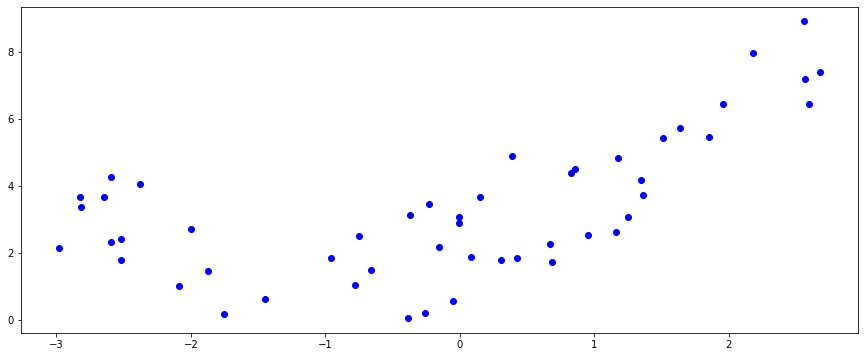

In [28]:
m = 50
#x = 2*np.random.rand(m,1)
x = 6*np.random.rand(m,1)-3
y = 0.5*x**2+x+2+np.random.randn(m,1)
plt.figure(figsize=(15,6))
plt.plot(x,y,'bo')

Let us split the dataset, so that one half of it is used to train the model, after which we measure the model's performance on the remaining half.

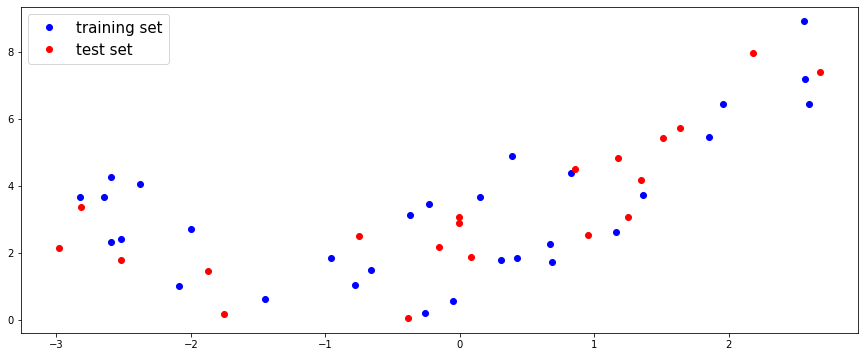

In [29]:
x_train,y_train = x[:30],y[:30] #first 30
x_test,y_test = x[30:],y[30:] #last 20

plt.figure(figsize=(15,6))
plt.plot(x_train,y_train,'bo',label='training set')
plt.plot(x_test,y_test,'ro',label='test set')
plt.legend(fontsize=15)

Let's fit degree-d polynomials to the data

$$
y = \theta_0 + \theta_1x+\theta_2x^2 + \cdots + \theta_d x^d
$$

In [7]:
max_degree = 20
degree_list = [d for d in range(max_degree+1)] #[0,1,2,3,...,max_degree]

MSE_test = np.zeros(max_degree+1)
MSE_train = np.zeros(max_degree+1)
for degree in degree_list: #fit a polynomial of degree d
    X_train = x_train**degree_list[:degree+1]
    X_test = x_test**degree_list[:degree+1]
    theta = np.linalg.lstsq(X_train,y_train,rcond=None)[0]
    MSE_train[degree]=np.linalg.norm(y_train-X_train@theta)/len(x_train)
    MSE_test[degree]=np.linalg.norm(y_test-X_test@theta)/len(x_test)

Text(0, 0.5, 'MSE')

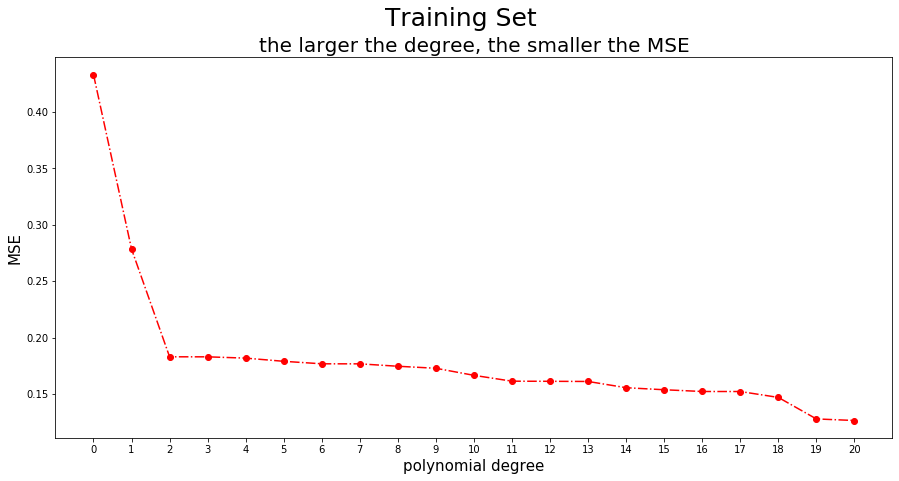

In [8]:
plt.figure(figsize=(15,7))
plt.plot(degree_list,MSE_train,'ro-.')
plt.title('the larger the degree, the smaller the MSE',fontsize=20)
plt.suptitle('Training Set',fontsize=25)
plt.xlabel('polynomial degree',fontsize=15)
plt.xticks(degree_list)
plt.ylabel('MSE',fontsize=15)

Let's plot the best fit degree-20 polynomial

Text(0.5, 1.0, 'MSE for the test set is 33.72785387119582')

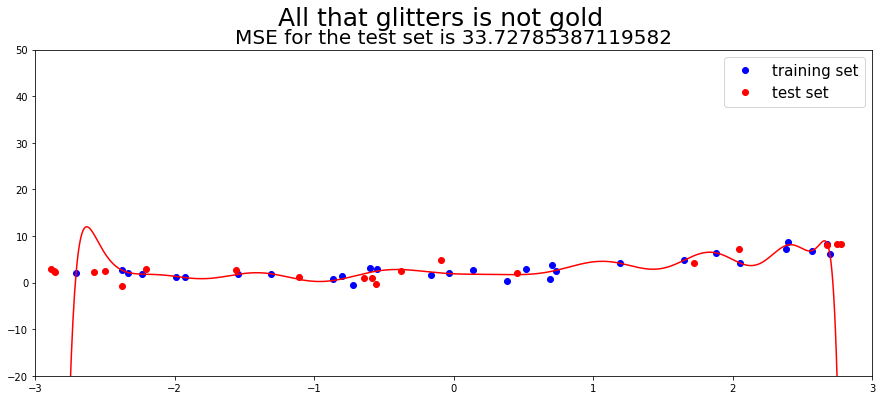

In [9]:
plt.figure(figsize=(15,6))

plt.plot(x_train,y_train,'bo',label = 'training set') #plot training set
plt.plot(x_test,y_test,'ro',label = 'test set') #plot test set
plt.legend(fontsize=15)

x_plot = np.linspace(-3,3,1000) #plot polynomial
x_plot = x_plot[:,None] #keep x_plot as a column vector
X_plot = x_plot**degree_list
y_plot = X_plot@theta
plt.plot(x_plot,y_plot,'r-')
plt.ylim(-20,50)
plt.xlim(-3,3)


plt.suptitle('Overfitted Model',fontsize=25)
X_test = x_test**degree_list
MSE_test_set = np.linalg.norm(y_test-X_test@theta)/len(x_test)
plt.title('MSE for the test set is '+str(MSE_test_set),fontsize=20)

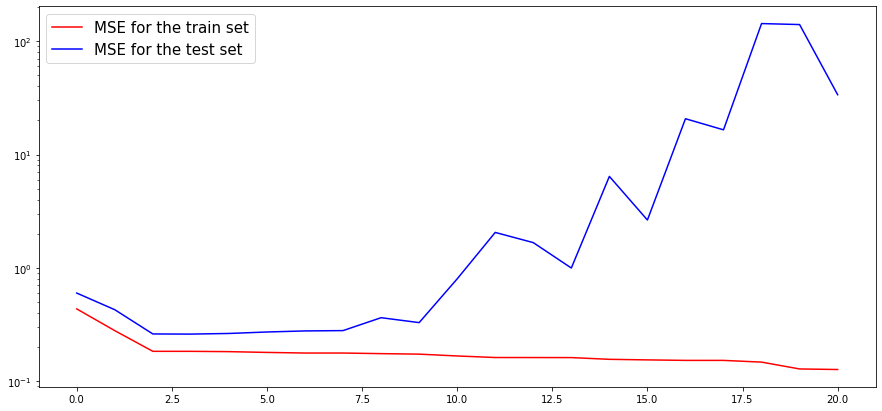

In [10]:
plt.figure(figsize=(15,7))
plt.semilogy(degree_list,MSE_train,'r-',label='MSE for the train set') #semilogarithmic plot
plt.semilogy(degree_list,MSE_test,'b-',label='MSE for the test set')
plt.legend(fontsize = 15)

## 3.2 Detecting Overfitting: Learning Curves

Learning curves are plots of the model's performance on the training set and the test set as a function of the training set size.
Learning curves is one way to tell when a model is too simple or too complex.

In [11]:
MSE_train = np.zeros(35)
MSE_test = np.zeros(35)

train_sizes = [s for s in range(35)]
deg = 20

for train_size in train_sizes: 
    x_train,y_train = x[:train_size+1],y[:train_size+1]
    x_test,y_test = x[train_size+1:],y[train_size+1:]
    
    #train the model (polynomial)
    X_train = x_train**[d for d in range(deg)]
    theta = np.linalg.lstsq(X_train,y_train,rcond=None)[0]
    #MSE for the training set
    MSE_train[train_size] = np.linalg.norm(y_train-X_train@theta)/(train_size)
    #MSE for the test set
    X_test = x_test**[d for d in range(deg)]
    MSE_test[train_size] = np.linalg.norm(y_test-X_test@theta)/(m-train_size)

C:\Users\javier.perez-alvaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


Text(0, 0.5, 'MSE')

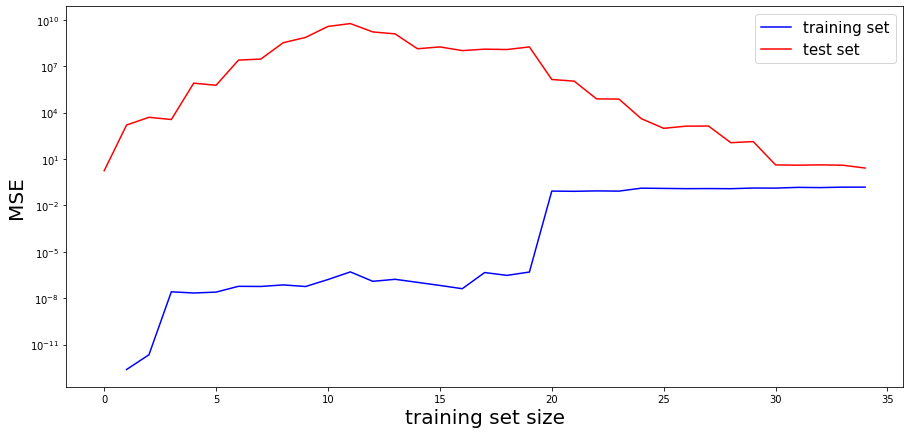

In [12]:
plt.figure(figsize=(15,7))
plt.semilogy(train_sizes,MSE_train,'-b',label='training set')
plt.semilogy(train_sizes,MSE_test,'r-',label='test set')
plt.legend(fontsize=15)
plt.xlabel('training set size',fontsize=20)
plt.ylabel('MSE',fontsize=20)

There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. 

If you used a much larger training set, however, the two curves would continue to get closer

## 3.3 Regularization using the 2-norm: Ridge Regression

We add a regularization term to the usual least squares problem:

$$
E(\theta) = \mbox{MSE}(\theta) + \frac{\lambda}{m}\cdot\|\theta\|_2^2 = \frac{1}{m}\|y-X\theta\|_2^2 + \frac{\lambda}{m}\cdot\|\theta\|_2^2
$$

The regularization term

$$
\frac{\lambda}{m}\cdot\|\theta\|_2^2
$$

will penalize vectors $\theta$ with large entries.

The gradient of $E(\theta)$ is given by

$$
\frac{2}{m}X^T(X\theta-y)+\frac{2\lambda}{m} \theta
$$

To find the vector $\theta$ that minimizes $E(\theta)$, we need to solve

$$
\nabla E(\theta) = 0
$$

The closed-form solution of $\nabla E(\theta) = 0$ is 

$$
\theta = (X^TX + \lambda I_n)^{-1}X^T y
$$

In [15]:
'generate a random data set'
m = 60
#x = 2*np.random.rand(m,1)
x = 6*np.random.rand(m,1)-3
y = 0.5*x**2+x+2+np.random.randn(m,1)

In [16]:
'split into training and test set'
x_train,y_train = x[:40],y[:40]
x_test,y_test = x[40:],y[40:]

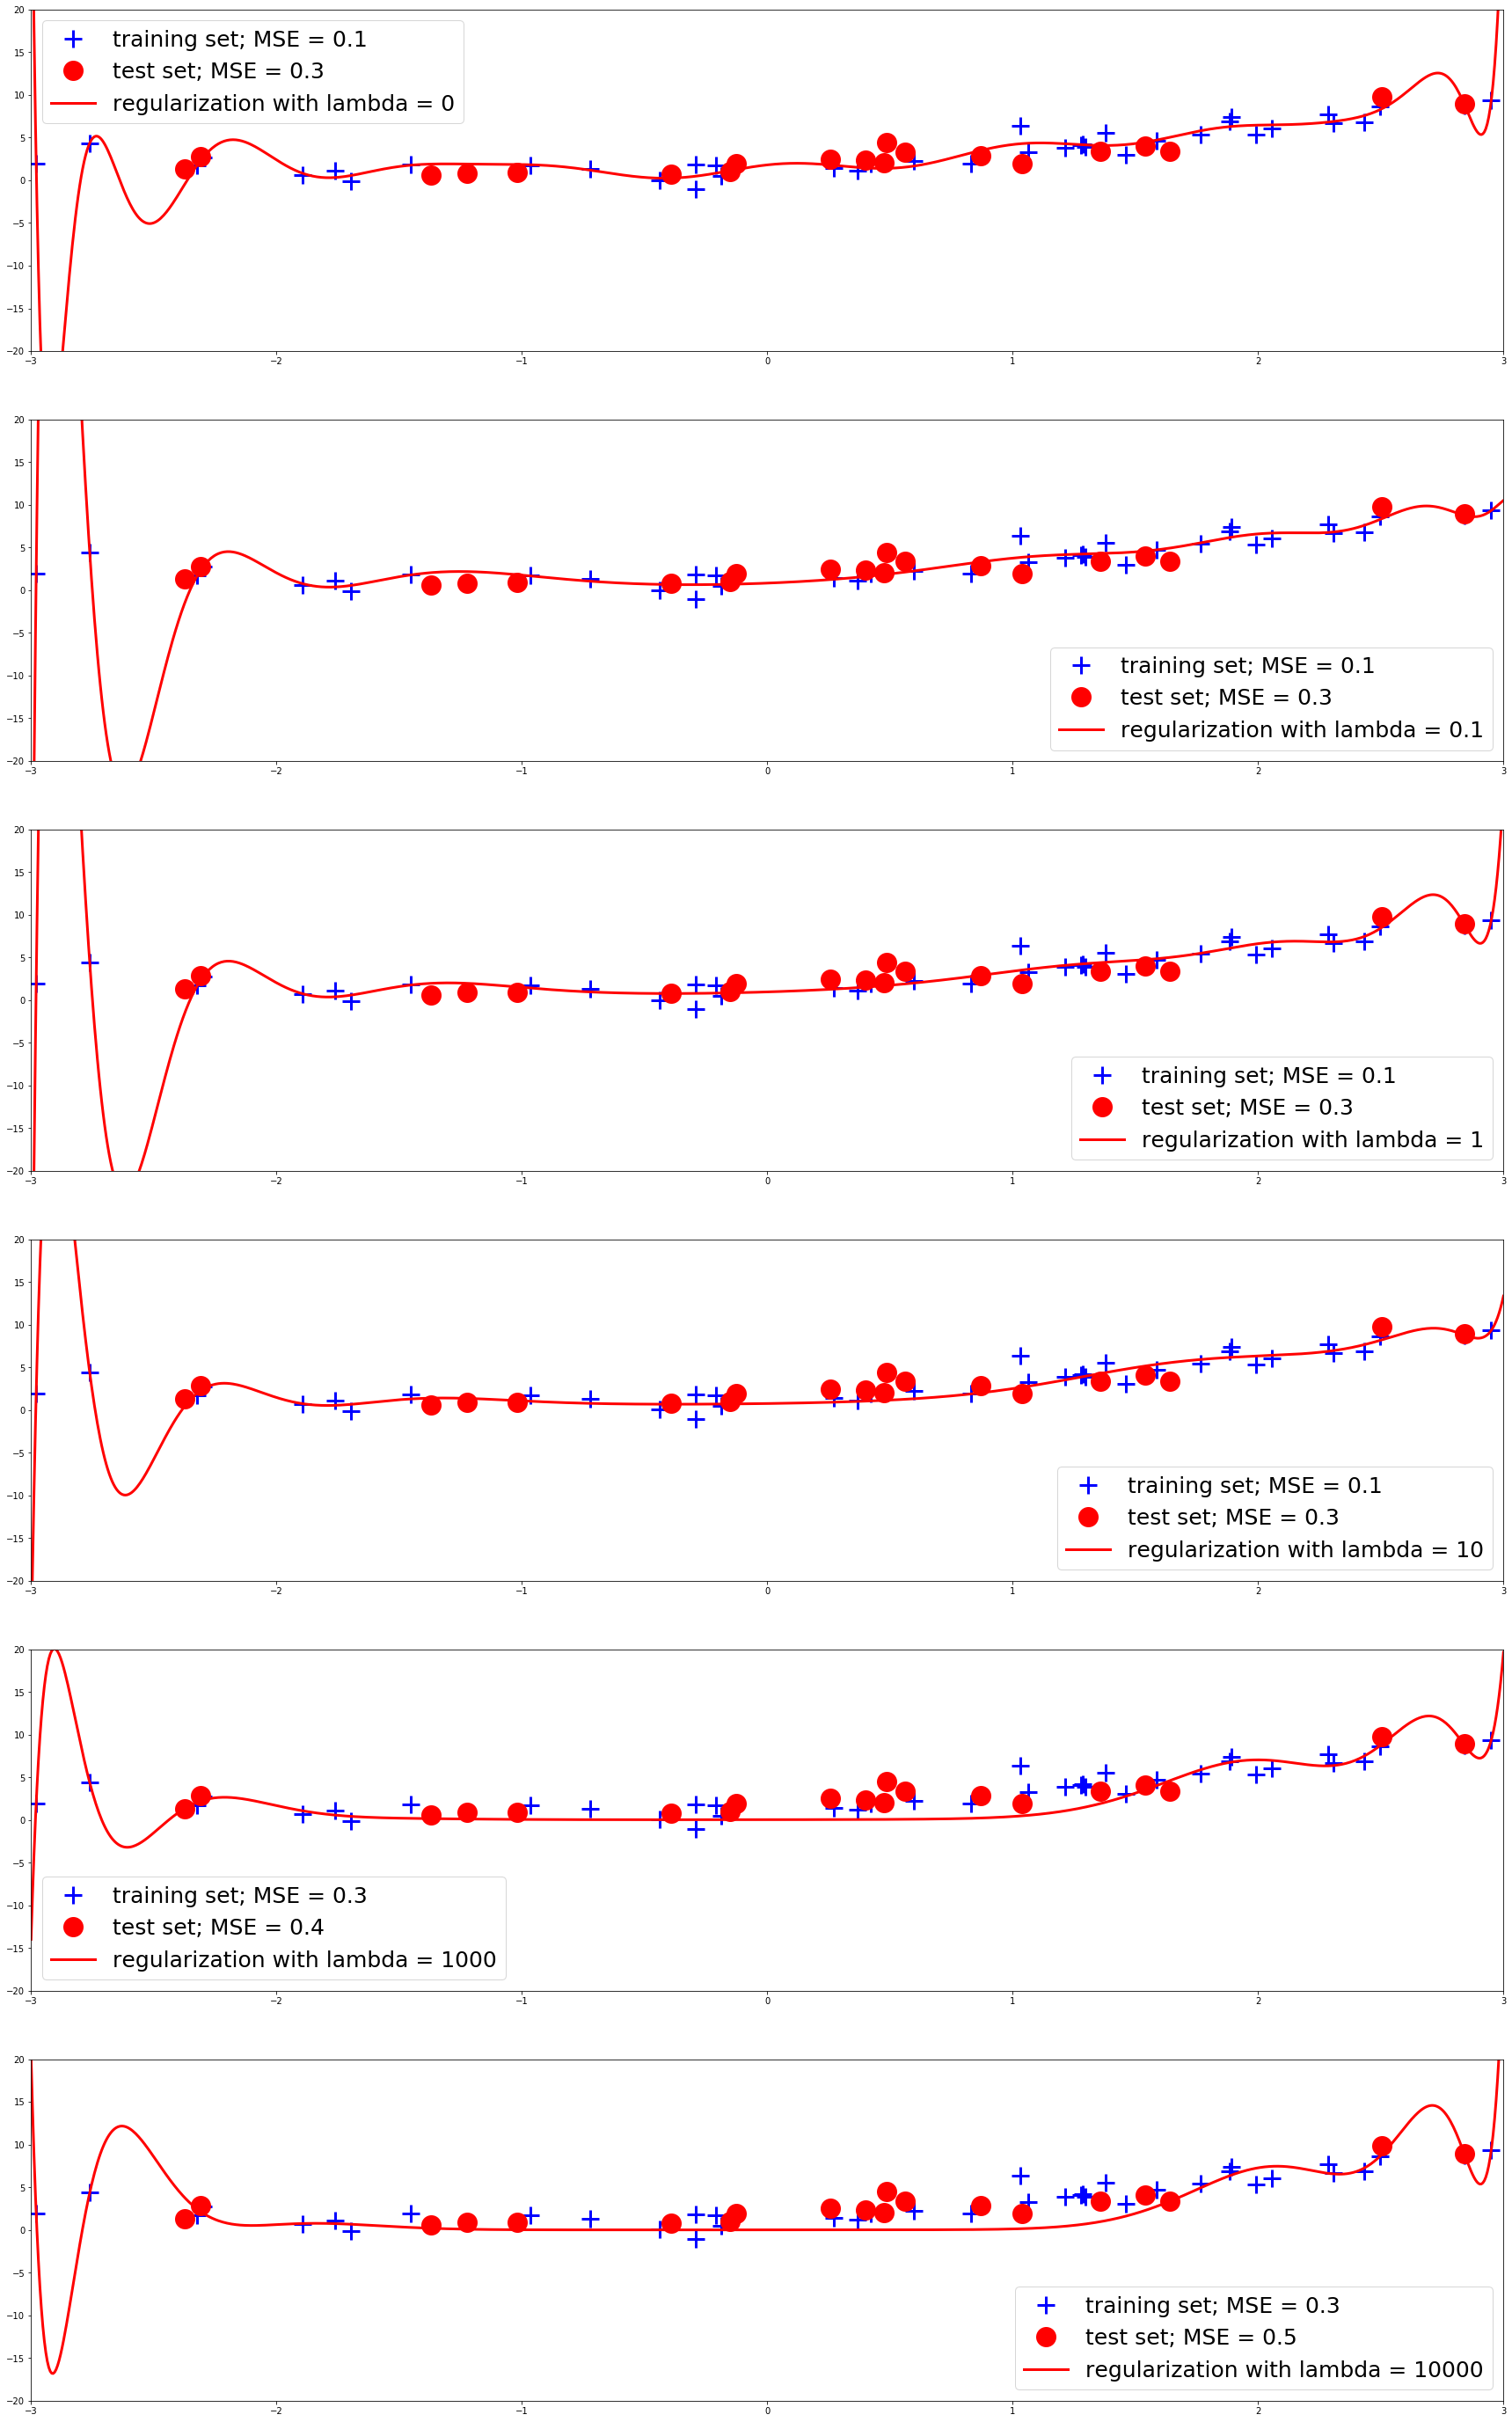

In [17]:
plt.figure(figsize=(30,50))

deg = 20 # We are going to fit a degree-20 polynomial to the training set
deg_list = list(range(deg+1))
X_train = x_train**[deg_list]
X_test = x_test**[deg_list]

x_plot = np.linspace(-3,3,1000) #We will need this to plot the polynomial
X_plot = x_plot[:,None]**deg_list

identity = np.identity(deg+1) #identity matrix

lambda_list = [0,0.1,1,10,1000,10000] 
for i in range(6):
    la = lambda_list[i]
    theta = np.linalg.solve(X_train.T@X_train+la*identity,X_train.T@y_train)
    
    MSE_train = np.linalg.norm(X_train@theta-y_train)/len(x_train)
    MSE_test = np.linalg.norm(X_test@theta-y_test)/len(x_test)
    
    y_plot = X_plot@theta
    
    plt.subplot(6,1,i+1)
    plt.plot(x_train,y_train,'b+',markersize=20,markeredgewidth=3, label='training set; MSE = '+str(round(MSE_train,1))) #plot training set
    plt.plot(x_test,y_test,'ro',markersize=20,markeredgewidth=3, label='test set; MSE = '+str(round(MSE_test,1))) #plot training set
    plt.plot(x_plot,y_plot,'r-',linewidth=3,label='regularization with lambda = '+str(la))
    plt.legend(fontsize=25)
    plt.ylim(-20,20)
    plt.xlim(-3,3)

### 3.2.1 Ridge Regression

In [547]:
'rigde regression using the closed-form solution formula'
def Rigde_regression(X,y,la):
    m,n = X.shape
    identity = np.identity(n)
    
    theta = np.linalg.solve(X.T@X+la*identity,X.T@y)
    
    return theta

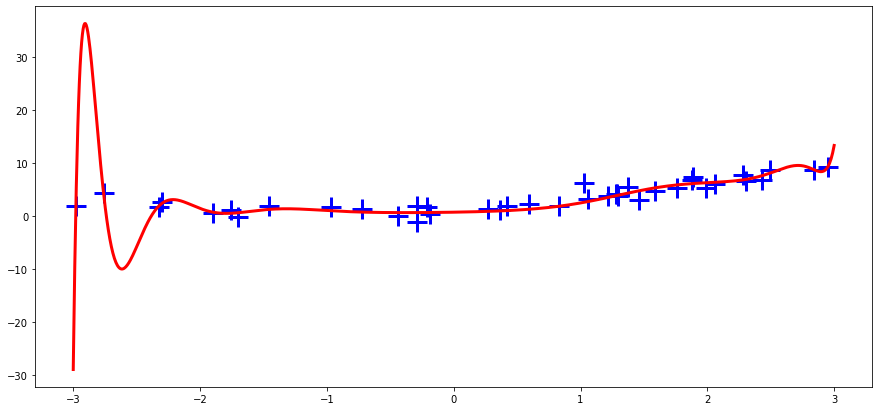

In [23]:
'test rigde_regression'
la = 10
theta = Rigde_regression(X_train,y_train,la)
y_plot = X_plot@theta

plt.figure(figsize=(15,7))
plt.plot(x_train,y_train,'b+',markersize=20,markeredgewidth=3, label='training set; MSE = '+str(MSE_train)) #plot training set
plt.plot(x_plot,y_plot,'r-',linewidth=3)

Text(0.5, 1.0, 'the larger $\\lambda$, the smaller the coefficients are')

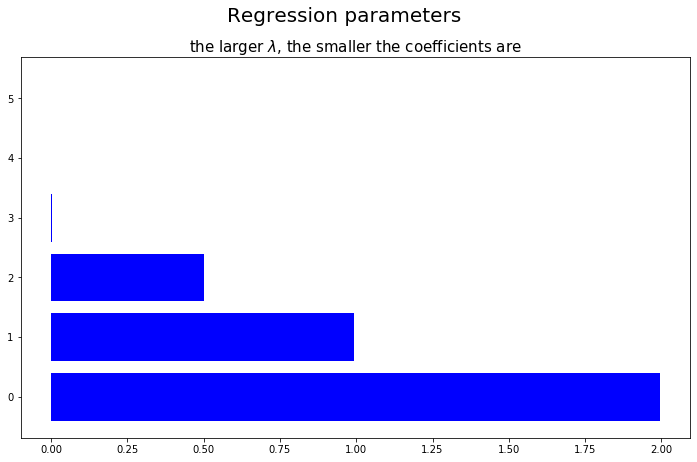

In [546]:
'plot model coefficients'
plt.figure(figsize=(12,7))
x_pos = [i for i  in range(len(theta))]
plt.barh(x_pos, theta.flatten(), color='blue') 
plt.suptitle('Regression parameters',fontsize=20)
plt.title('the larger $\lambda$, the smaller the coefficients are',fontsize=15)

## 3.4 Regularization using the 1-norm: Lasso Regression

We add a regularization term to the usual least squares problem:

$$
E(\theta) = \mbox{MSE}(\theta) + \frac{\lambda}{m}\|\theta\|_1^2 = \frac{1}{m}\|y-X\theta\|_2^2 + \frac{\lambda}{m}\|\theta\|_1^2
$$

There is no closed-form solution of $\nabla E(\theta)=0$. So we need to use iterative methods (like Gradient Descent)

### 3.4.1 Lasso using Gradient Descent

Gredient Descent works fine if you use a subgradient

$$
\frac{2}{m}X^T(X\theta-y)+\frac{\lambda}{m} 
\begin{bmatrix}
\mbox{sign}(\theta_1)\\
\mbox{sign}(\theta_2)\\
\vdots \\
\mbox{sign}(\theta_n)
\end{bmatrix} 
\qquad \mbox{where} \qquad
\mbox{sign}(\theta_i) = 
\left\{ \begin{array}{cc}
-1 & \mbox{ if }\theta_i<0, \\
0 & \mbox{ if }\theta_i = 0, \\
1 & \mbox{ if }\theta_i>0
\end{array}\right.
$$

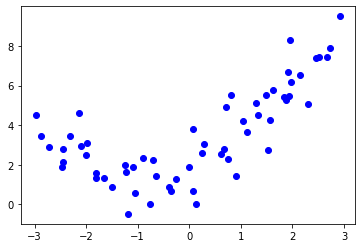

In [3]:
'generate a random data set'
np.random.seed(10)
m = 60
#x = 2*np.random.rand(m,1)
x = 6*np.random.rand(m,1)-3
y = 0.5*x**2+x+2+np.random.randn(m,1)
plt.plot(x,y,'ob')

In [9]:
'split into training and test set'
x_train,y_train = x[:40],y[:40]
x_test,y_test = x[40:],y[40:]

x_plot = np.linspace(-3,3,1000) #We will need this to plot the polynomial

In [6]:
def Lasso_regression_GD(X,y,s,n_iterations,la):
    m,n = X.shape
    theta = np.random.randn(n,1)
    MSE = np.zeros(n_iterations)
    for i in range(n_iterations):
        gradient = 2*X.T@(X@theta-y)/m + (la/m)*np.sign(theta)
        theta = theta - s*gradient
        #MSE[i] = np.linalg.norm(gradient)
        MSE[i] = np.linalg.norm(X@theta-y)/m
    return MSE,theta

In [10]:
deg = 5 # We are going to fit a degree-5 polynomial to the training set
deg_list = list(range(deg+1))

X_train = x_train**[deg_list]

In [11]:
la = 0.1
s = 0.0001
n_iterations = 10000

MSE, theta = Lasso_regression_GD(X_train,y_train,s,n_iterations,la)

Text(0.5, 1.0, 'Slow convergence of GD')

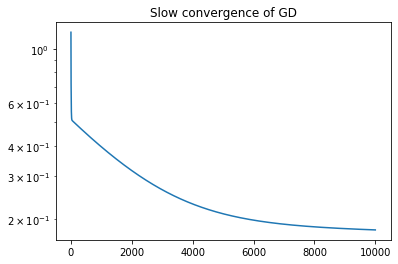

In [13]:
plt.semilogy(MSE)
plt.title('Slow convergence of GD')

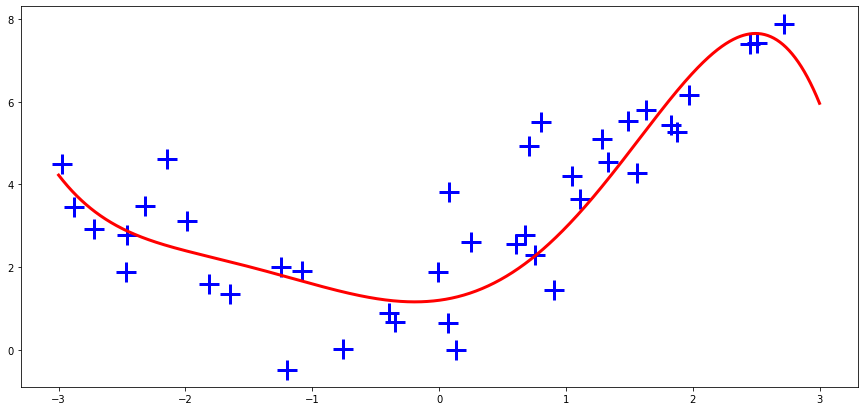

In [14]:
X_plot = x_plot[:,None]**deg_list
y_plot = X_plot@theta

plt.figure(figsize=(15,7))
plt.plot(x_train,y_train,'b+',markersize=20,markeredgewidth=3) #plot training set
plt.plot(x_plot,y_plot,'r-',linewidth=3)

### 3.4.2 Lasso with ADMM

In [16]:
'shrinkage function'
def shrinkage(x,k):
    #return np.maximum(0,x-k)-np.maximum(0,-x-k)
    return x*np.maximum(0,1-k/np.abs(x))

In [18]:
def Lasso_regression_ADMM(X,y,s,n_iterations,la):
    m,n = X.shape
    
    theta = np.zeros((n,1)) #or a random vector
    z = np.zeros((n,1))
    u = np.zeros((n,1))
    
    theta = np.random.rand(n,1)
    z = np.random.rand(n,1)
    u = np.random.rand(n,1)
    
    MSE = np.zeros(n_iterations)
    for i in range(n_iterations):
        #theta-update:
        q = X.T@y+s*(z-u) 
        theta = np.linalg.solve(X.T@X+s*np.identity(n),q)
        #z-update
        z = shrinkage(theta+u,la/s)
        #u-update
        u = u+theta-z
        MSE[i] = np.linalg.norm(X@theta-y)/m
    return MSE, theta

In [21]:
la = 0.1
s = 1
alpha = 1
n_iterations = 20

MSE, theta = Lasso_regression_ADMM(X_train,y_train,s,n_iterations,la)

Text(0.5, 1.0, 'lightning fast convergence')

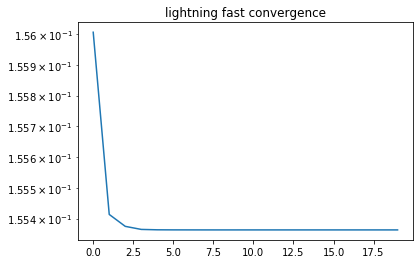

In [24]:
plt.semilogy(MSE)
plt.title('lightning fast convergence')

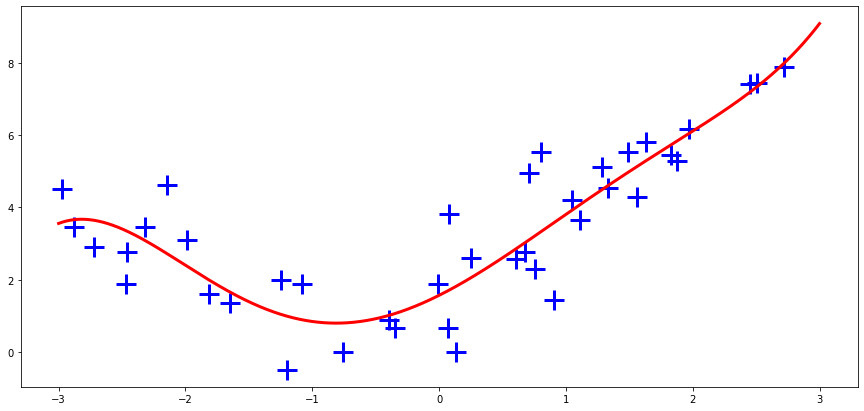

In [25]:
X_plot = x_plot[:,None]**deg_list
y_plot = X_plot@theta

plt.figure(figsize=(15,7))
plt.plot(x_train,y_train,'b+',markersize=20,markeredgewidth=3) #plot training set
plt.plot(x_plot,y_plot,'r-',linewidth=3)

### 4.3.2 Ridge vs Lasso (1-norm vs 2-norm)

In [27]:
deg = 15 # We are going to fit a degree-15 polynomial to the training set
deg_list = list(range(deg+1))

X_train = x_train**[deg_list]

(-10, 10)

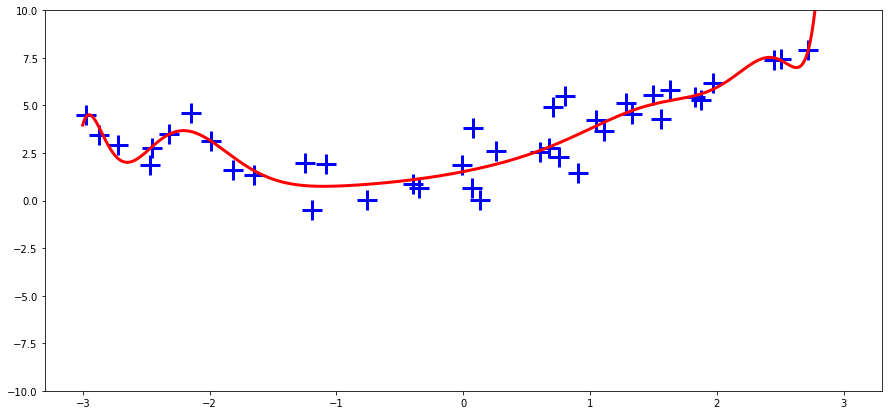

In [31]:
X_plot = x_plot[:,None]**deg_list
y_plot = X_plot@theta

plt.figure(figsize=(15,7))
plt.plot(x_train,y_train,'b+',markersize=20,markeredgewidth=3) #plot training set
plt.plot(x_plot,y_plot,'r-',linewidth=3)
plt.ylim(-10,10)

In [32]:
la = 1
s = 2
n_iterations =  10

MSE, theta = Lasso_regression_ADMM(X_train,y_train,s,n_iterations,la)

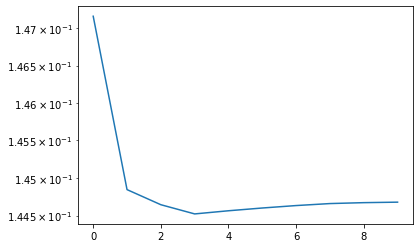

In [33]:
plt.semilogy(MSE)

Text(0.5, 1.0, '1-norm regression')

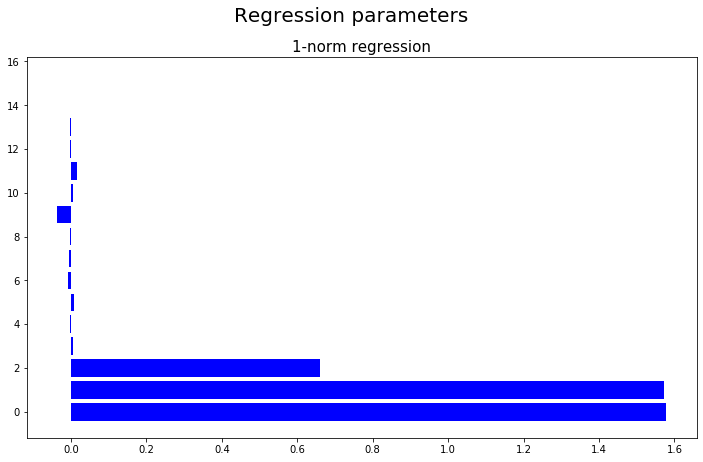

In [34]:
plt.figure(figsize=(12,7))
x_pos = [i for i  in range(len(theta))]
plt.barh(x_pos, theta.flatten(), color='blue') 
plt.suptitle('Regression parameters',fontsize=20)
plt.title('1-norm regression',fontsize=15)

(-10, 10)

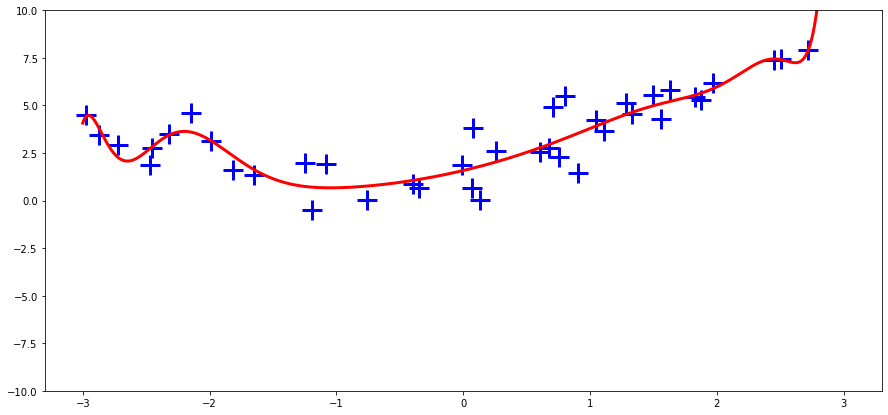

In [35]:
X_plot = x_plot[:,None]**deg_list
y_plot = X_plot@theta

plt.figure(figsize=(15,7))
plt.plot(x_train,y_train,'b+',markersize=20,markeredgewidth=3) #plot training set
plt.plot(x_plot,y_plot,'r-',linewidth=3)
plt.ylim(-10,10)

## 4.4 Early stopping of Gradient Descent: regularization without a regularization term

A very different way to regularize a linear model is to stop Gradient Descent (or Stochastic Gradient Descent) as soon as the test error rearches a minimum.

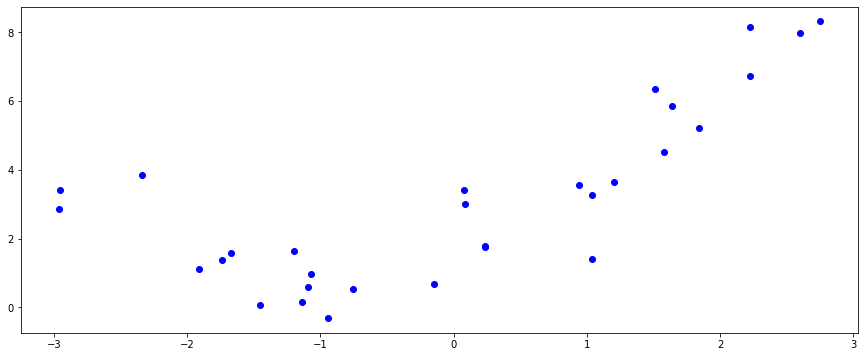

In [148]:
m = 30
np.random.seed(14)
x = 6*np.random.rand(m,1)-3
y = 0.5*x**2+x+2+np.random.randn(m,1)
plt.figure(figsize=(15,6))
plt.plot(x,y,'bo')

In [149]:
'split into training and test set'
x_train,y_train = x[:20],y[:20]
x_test,y_test = x[20:],y[20:]

(-30, 30)

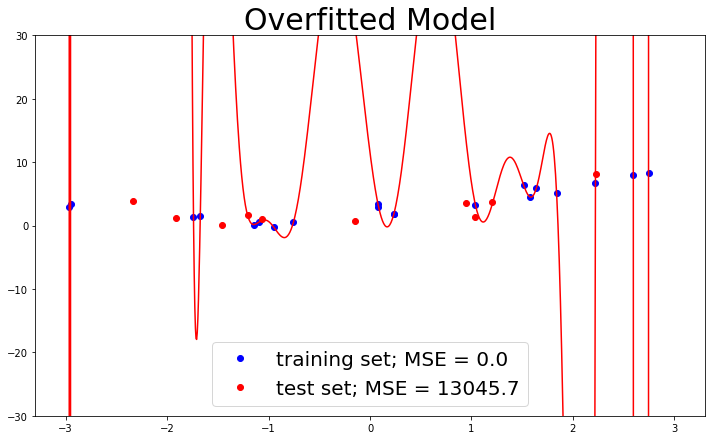

In [150]:
'Degree 20 polynomial fitting'
deg = 20
deg_list = list(range(deg+1))
X_train = x_train**[deg_list]
X_test = x_test**[deg_list]

'Solve the least squares problem'
theta = np.linalg.lstsq(X_train,y_train,rcond=None)[0]

x_plot = np.linspace(-3,3,1000) #We will need this to plot the polynomial
X_plot = x_plot[:,None]**[deg_list]
y_plot = X_plot@theta


'MSE errors for the training and test datasets'
MSE_train = np.linalg.norm(y_train-X_train@theta)/len(x_train)
MSE_test = np.linalg.norm(y_test-X_test@theta)/len(x_train)

plt.figure(figsize=(12,7))
plt.plot(x_train,y_train,'bo', label = 'training set; MSE = ' + str(round(MSE_train,1)))
plt.plot(x_test,y_test,'ro', label = 'test set; MSE = ' + str(round(MSE_test,1)))
plt.plot(x_plot,y_plot,'r-')
plt.legend(fontsize=20)
plt.title('Overfitted Model',fontsize = 30)
plt.ylim(-30,30)

In [190]:
'Solve the least squares problem with Gradient Descent'
#scale matrix X_train to avoid overflow
d = np.amax(np.abs(X_train),axis=0)
X_train_scaled = X_train/d

'Gradient Descent'
s = .3
n_iterations = 20000
MSE_train = np.zeros((n_iterations,1)) 
MSE_test = np.zeros((n_iterations,1)) 
theta_hat = np.random.rand(deg+1,1) #random initialization
for it in range(n_iterations):
    gradient = (2/len(x_train))*X_train_scaled.T@(X_train_scaled@theta_hat-y_train)
    theta_hat = theta_hat - s*gradient
    theta = theta_hat/d[:,None]
    MSE_train[it] = np.linalg.norm(y_train-X_train@theta)/len(x_train)
    MSE_test[it] = np.linalg.norm(y_test-X_test@theta)/len(x_train)

Text(600, 0.2, 'best model')

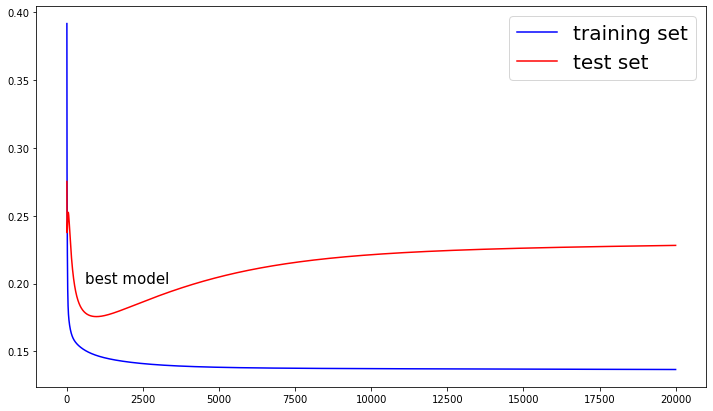

In [191]:
plt.figure(figsize=(12,7))
plt.plot(MSE_train,'b',label = 'training set')
plt.plot(MSE_test,'r', label = 'test set')
plt.legend(fontsize=20)
plt.text(600,.2,'best model',fontsize=15)

Text(0.5, 1.0, 'Sometimes slowness is a blessing')

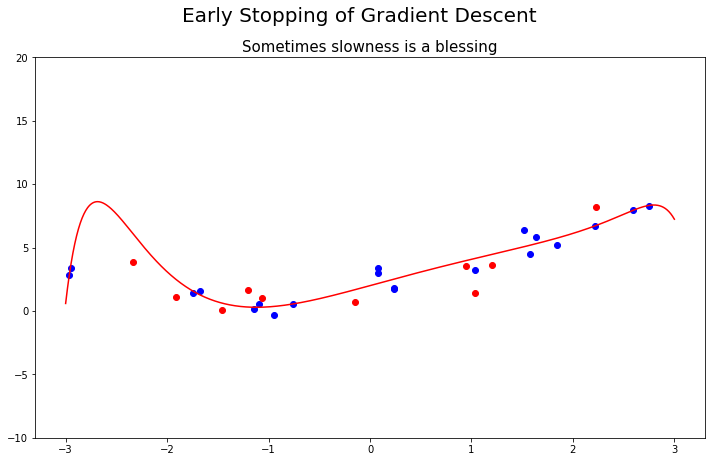

In [192]:
x_plot = np.linspace(-3,3,1000) #We will need this to plot the polynomial
X_plot = x_plot[:,None]**[deg_list]
y_plot = X_plot@theta


plt.figure(figsize=(12,7))
plt.plot(x_train,y_train,'bo')
plt.plot(x_test,y_test,'ro')
plt.plot(x_plot,y_plot,'r-')
plt.ylim(-10,20)
plt.suptitle('Early Stopping of Gradient Descent',fontsize=20)
plt.title('Sometimes slowness is a blessing',fontsize=15)

In [193]:
'Solve the least squares problem with Stochastic Gradient Descent'
#scale matrix X_train to avoid overflow
d = np.amax(np.abs(X_train),axis=0)
#d = 2*np.ones(deg+1)
X_train_scaled = X_train/d

'Stochastic Gradient Descent'
s = .3
n_iterations = 10000
MSE_train = np.zeros((n_iterations,1)) 
MSE_test = np.zeros((n_iterations,1)) 
theta_hat = np.random.rand(deg+1,1) #random initialization
for it in range(n_iterations):
    for i in range(len(x_train)): 
        random_row = np.random.randint(len(x_train)) 
        xi = X_train_scaled[random_row] #ith row; 
        xi = xi[None,:] #keep xi as a row vector
        yi = y_train[random_row]
        gradient = (2/len(x_train))*xi.T@(xi@theta_hat-yi)
        theta_hat = theta_hat - s*gradient
    theta = theta_hat/d[:,None]
    MSE_train[it] = np.linalg.norm(y_train-X_train@theta)/len(x_train)
    MSE_test[it] = np.linalg.norm(y_test-X_test@theta)/len(x_train)

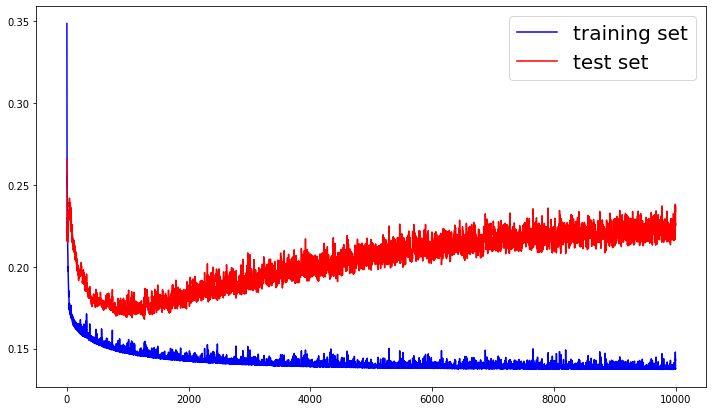

In [194]:
plt.figure(figsize=(12,7))
plt.plot(MSE_train,'b',label = 'training set')
plt.plot(MSE_test,'r', label = 'test set')
plt.legend(fontsize=20)

Text(0.5, 1.0, 'Sometimes slowness is a blessing')

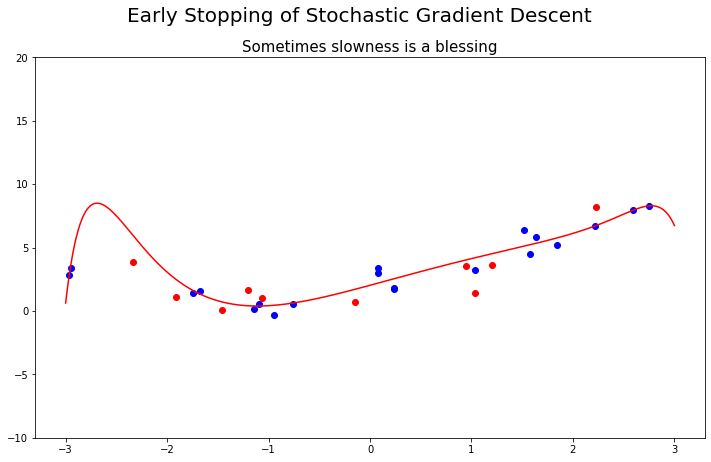

In [196]:
x_plot = np.linspace(-3,3,1000) #We will need this to plot the polynomial
X_plot = x_plot[:,None]**[deg_list]
y_plot = X_plot@theta


plt.figure(figsize=(12,7))
plt.plot(x_train,y_train,'bo')
plt.plot(x_test,y_test,'ro')
plt.plot(x_plot,y_plot,'r-')
plt.ylim(-10,20)
plt.suptitle('Early Stopping of Stochastic Gradient Descent',fontsize=20)
plt.title('Sometimes slowness is a blessing',fontsize=15)